In [425]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit

from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [426]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/NettekovenSym32_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
# info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{split_mn[0]}.lut')
labels=labels[1:]

# load profile
profile_orig = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/{fileparts[-1].split("_")[0]}_profile_individ.tsv', sep="\t"
)

# Make condition into row index and drop everything other than parcel columns
profile_orig = profile_orig.set_index('condition')
# Remove datasets
remove = ['Nishimoto', 'IBC']
# remove = ['Pontine', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic']
profile_orig = profile_orig[~profile_orig['dataset'].isin(remove)]
profile = deepcopy(profile_orig)
profile = profile[labels]

# Make profile into matrix
profile_mat = profile[labels].to_numpy()



In [427]:
# Make condition into row index and drop everything other than parcel columns
tasks = profile.index.tolist()

# Make profile into matrix
profile_mat = profile[labels].to_numpy()

# Plot Profile for subject 02 & 03

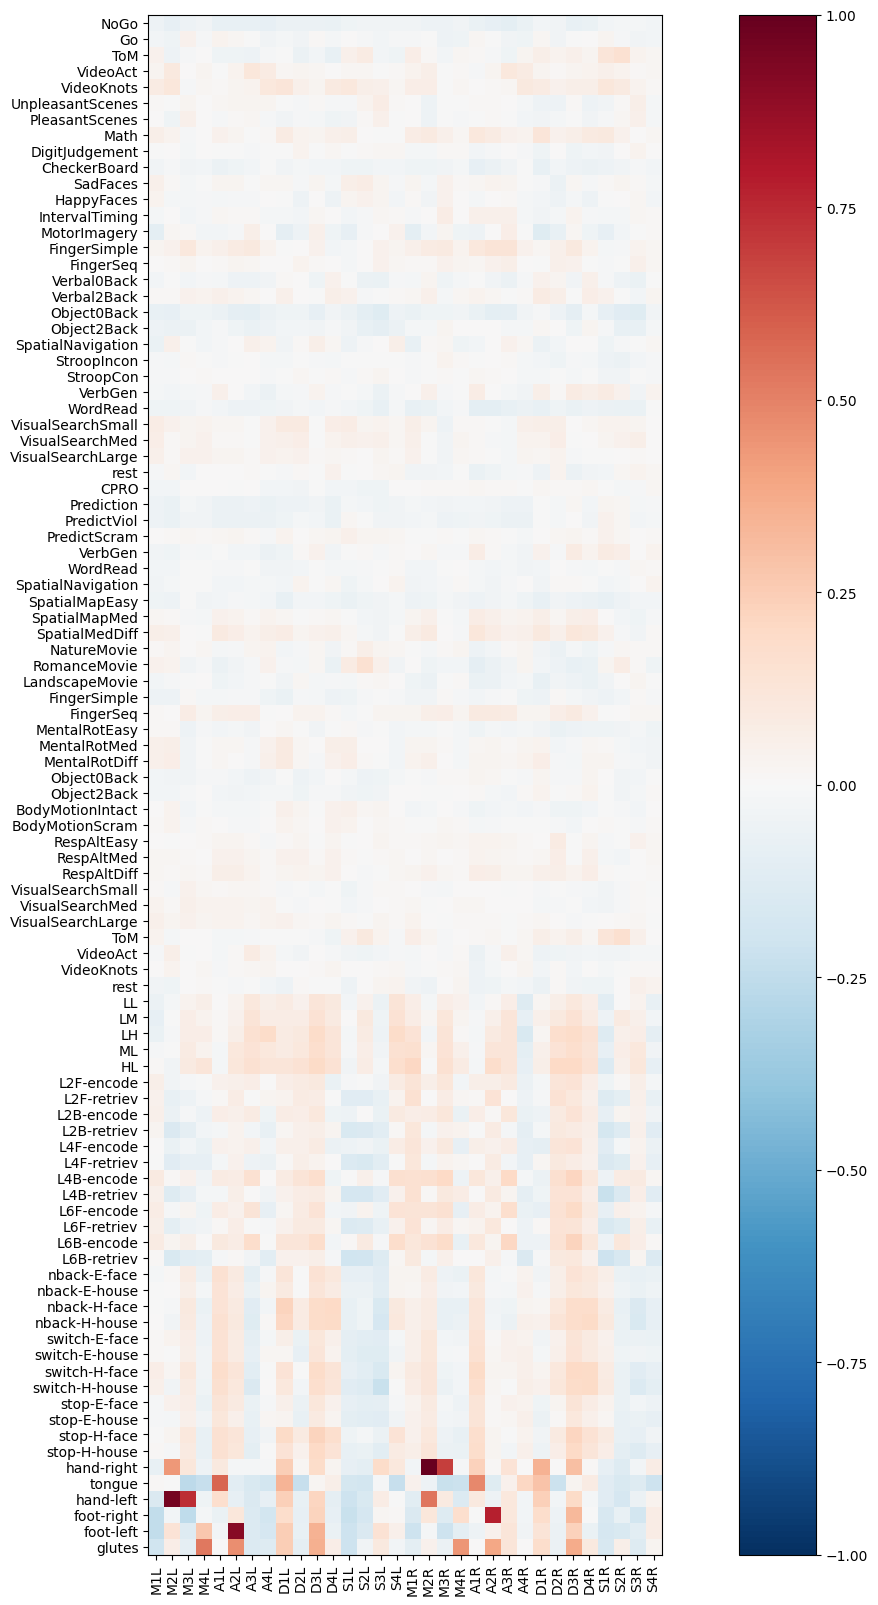

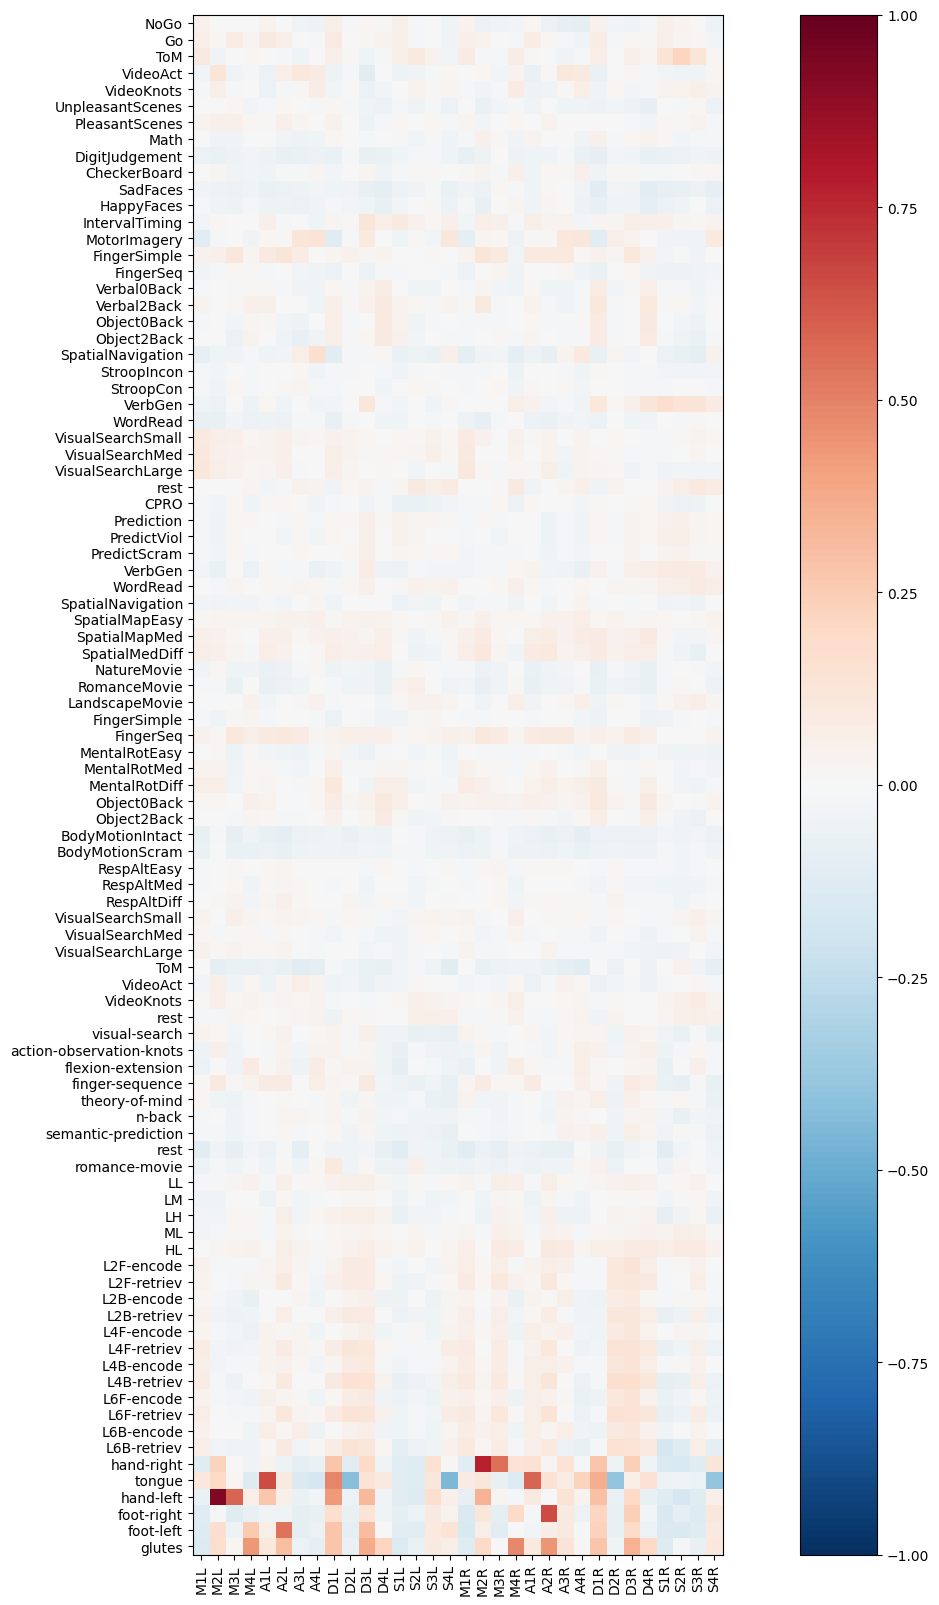

In [428]:
cmap_matrix = plt.get_cmap('RdBu_r')

participant='02'
participant_rows = profile_orig.participant_id == f'sub-{participant}'

plt.figure(figsize=(20, 20))
plt.imshow(profile_mat[participant_rows], cmap=cmap_matrix, vmin=-1, vmax=1)
plt.xticks(range(profile.shape[1]), profile.columns.tolist(), rotation=90)
plt.yticks(range(profile[participant_rows].shape[0]), profile[participant_rows].index.tolist())
plt.colorbar()


participant='03'
participant_rows = profile_orig.participant_id == f'sub-{participant}'

plt.figure(figsize=(20, 20))
plt.imshow(profile_mat[participant_rows], cmap=cmap_matrix, vmin=-1, vmax=1)
plt.xticks(range(profile.shape[1]), profile.columns.tolist(), rotation=90)
plt.yticks(range(profile[participant_rows].shape[0]), profile[participant_rows].index.tolist())
plt.colorbar()

# Add a row of rest for each participant in each dataset other than MDTB

In [429]:
profile_rest = deepcopy(profile_orig)
label_columns = [ i for i, label in enumerate(profile_rest.columns) if label in labels]
dset_part = zip(profile_rest.dataset, profile_rest.participant_id,  profile_rest.session)
# get unique combinations in original order
dset_part = list(dict.fromkeys(dset_part))
# Make index into column
profile_rest['condition'] = profile_rest.index
profile_rest = profile_rest.reset_index(drop=True)


for dataset, participant, session in dset_part:
    participant_rows = (profile_rest.participant_id == participant) & (profile_rest.dataset == dataset) & (profile_rest.session == session)
    if dataset == 'MDTB' or dataset == 'Pontine':
        # subtract rest from all other MDTB tasks
        
        rest_row = (participant_rows) & (profile_rest.condition == 'rest')
        rest_profile = profile_mat[rest_row]
                
        profile_rest.iloc[np.where(participant_rows)[0],label_columns] = profile_mat[participant_rows] - np.repeat(profile_mat[rest_row], profile_mat[participant_rows].shape[0], axis=0)
    else:              
        # Insert an empty row after the last participant row
        insert_rest = pd.Series([dataset, session, participant] + [0] * (len(profile_rest.columns) - 4) + ['rest'], index=profile_rest.columns)
        insert_index = np.where(participant_rows)[0][-1] + 1
        profile_rest.loc[insert_index] = insert_rest       

# Make condition into row index and drop condition column
profile_rest = profile_rest.set_index('condition')
profile_mat = profile_rest[labels].to_numpy()


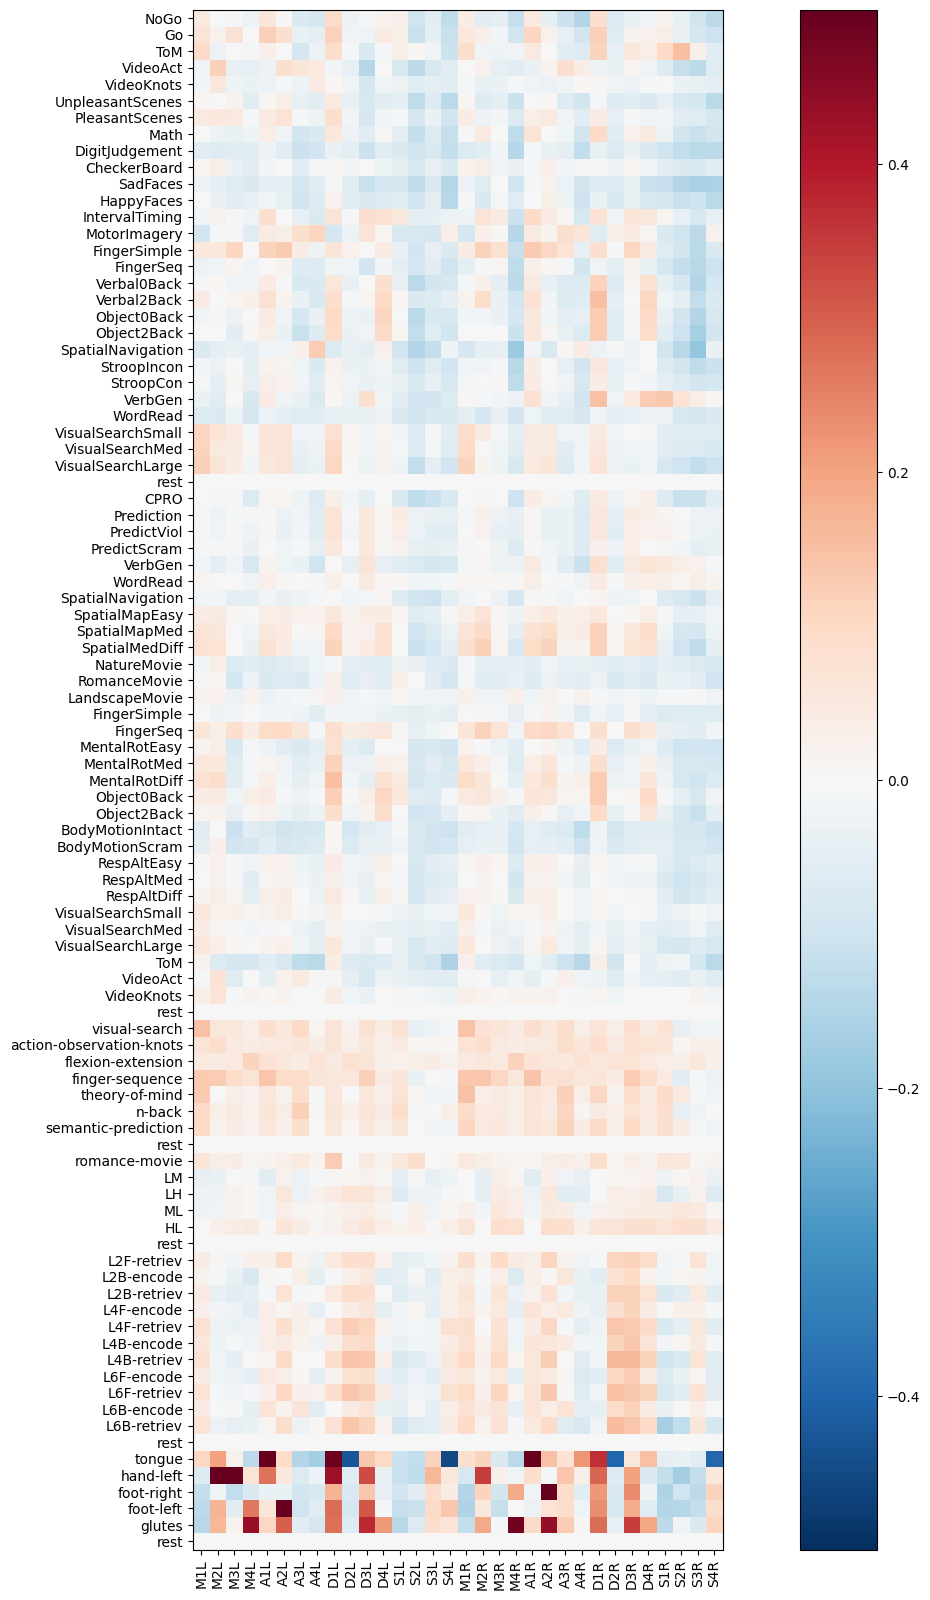

In [435]:

participant='03'
participant_rows = (profile_rest.participant_id == f'sub-{participant}') 

plt.figure(figsize=(20, 20))
plt.imshow(profile_rest[participant_rows][labels], cmap=cmap_matrix, vmin=-0.5, vmax=0.5)
plt.xticks(range(profile.shape[1]), profile.columns.tolist(), rotation=90)
plt.yticks(range(profile_rest[participant_rows].shape[0]), profile_rest[participant_rows].index.tolist())
plt.colorbar()


# Load cognitive feature tags

In [498]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags_final.tsv', sep="\t"
)
# Remove datasets
tags = tags[~tags['dataset'].isin(remove)]
# Remove all columns that are zero in all rows
tags = tags.loc[:, (tags != 0).any(axis=0)]
# Make condition into index 
tags = tags.set_index('condition')


In [499]:
# Subtract rest row from all other rows
tags_rest = deepcopy(tags)
# drop dataset and session columns
tags_rest = tags_rest.drop(['dataset', 'session'], axis=1)
rest_idx = np.where(tags_rest.index == 'Rest')[0][0]
rest_row = tags_rest.iloc[rest_idx]
# Subtract rest row from all other rows
tags_rest = tags_rest - rest_row

In [530]:
# Repeat the tags for each participant
# Loop through the entries of profile.condition and repeat the tags.condition row 
mdtb_new = [
    "VideoAct",
    "VisualSearchSmall",
    "VisualSearchLarge",
    "SpatialMedDiff",
    "rest",
]
mdtb_old = [
    "VideoActions",
    "VisualSearchEasy",
    "VisualSearchMed",
    "SpatialMapDiff",
    "Rest",
]
mdtb_new2old = dict(zip(mdtb_new, mdtb_old))


for i, cond in enumerate(profile_rest.index):
    try:
        row = tags_rest.iloc[tags_rest.index.tolist().index(cond)]
    except:
        row = tags_rest.iloc[tags_rest.index.tolist().index(mdtb_new2old[cond])]
    if i == 0:
        tags_cond = row
    else:
        tags_cond = pd.concat([tags_cond, row], axis=1)

# Rename columns using mdtb_new2old dictionary
mdtb_old2new = dict(zip(mdtb_old, mdtb_new))
tags_cond = tags_cond.rename(columns=mdtb_old2new)
# tags_cond = tags_cond.drop(['dataset', 'session'], axis=0)
tags_mat = tags_cond.T.to_numpy()



([<matplotlib.axis.YTick at 0x7f8627bce190>,
 [Text(0, 0, 'NoGo'),
  Text(0, 1, 'Go'),
  Text(0, 2, 'ToM'),
  Text(0, 3, 'VideoAct'),
  Text(0, 4, 'VideoKnots'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 6, 'PleasantScenes'),
  Text(0, 7, 'Math'),
  Text(0, 8, 'DigitJudgement'),
  Text(0, 9, 'CheckerBoard'),
  Text(0, 10, 'SadFaces'),
  Text(0, 11, 'HappyFaces'),
  Text(0, 12, 'IntervalTiming'),
  Text(0, 13, 'MotorImagery'),
  Text(0, 14, 'FingerSimple'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 16, 'Verbal0Back'),
  Text(0, 17, 'Verbal2Back'),
  Text(0, 18, 'Object0Back'),
  Text(0, 19, 'Object2Back'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 21, 'StroopIncon'),
  Text(0, 22, 'StroopCon'),
  Text(0, 23, 'VerbGen'),
  Text(0, 24, 'WordRead'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 26, 'VisualSearchLarge'),
  Text(0, 27, 'VisualSearchLarge'),
  Text(0, 28, 'rest'),
  Text(0, 29, 'CPRO'),
  Text(0, 30, 'Prediction'),
  Text(0, 31, 'PredictViol'),
  Text(0, 32, 'PredictScram')

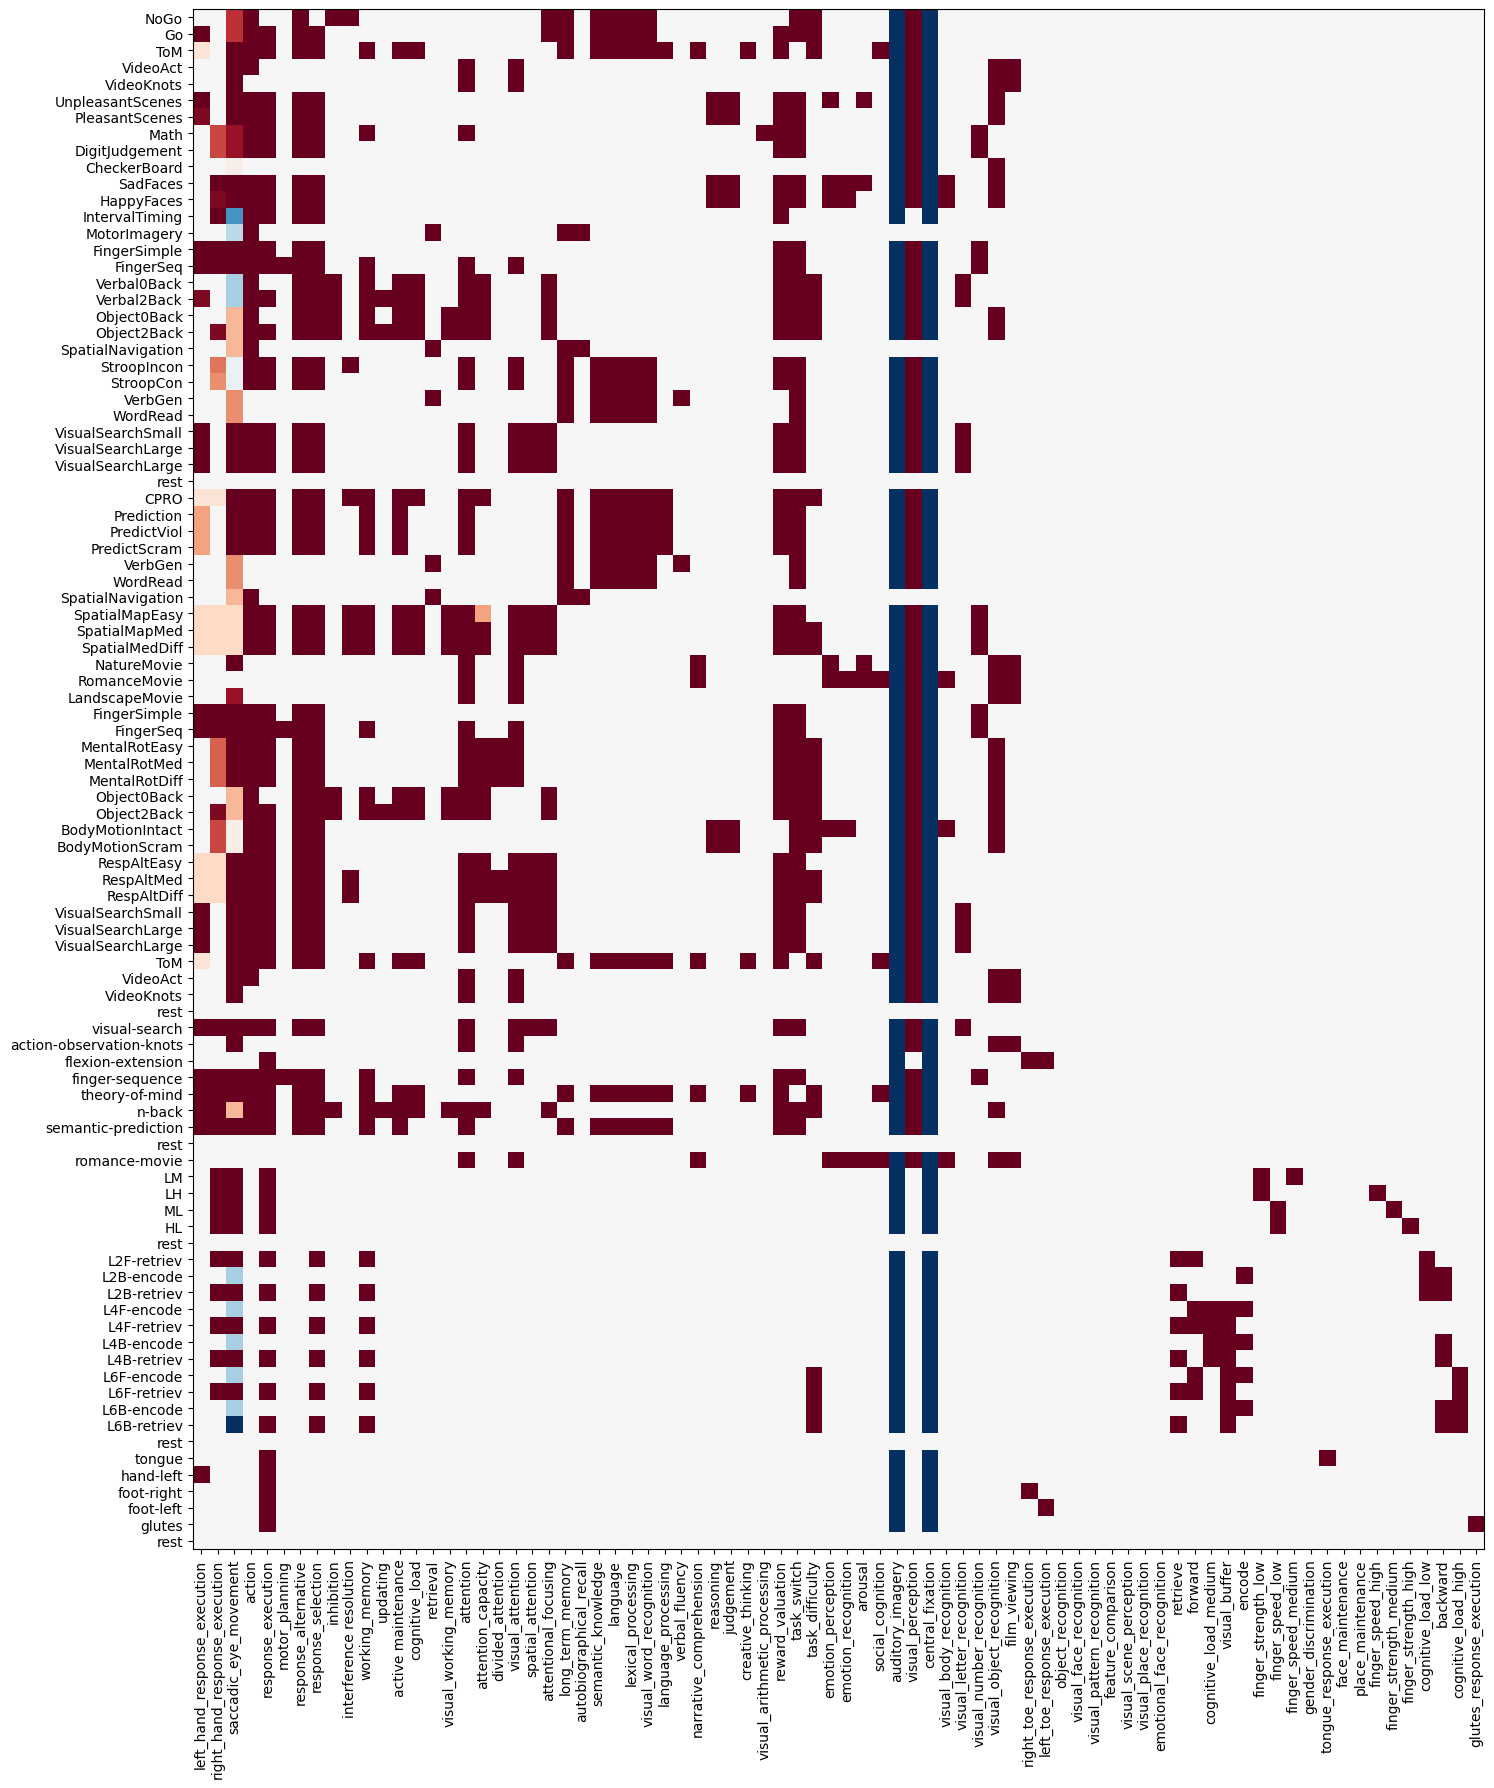

In [532]:
participant='03'
participant_rows = (profile_rest.participant_id == f'sub-{participant}') 

plt.figure(figsize=(20, 20))
plt.imshow(tags_mat[participant_rows], cmap=cmap_matrix, vmin=-0.5, vmax=0.5)
plt.xticks(range(tags_cond.shape[0]), tags_cond.index.tolist(), rotation=90)
plt.yticks(range(len(np.where(participant_rows)[0])), tags_cond.iloc[:,np.where(participant_rows)[0]].columns)
# plt.colorbar()


In [538]:
profile_mat = profile_rest[labels].to_numpy()


In [528]:
tags_mat.shape

(2301, 78)

In [539]:
profile_mat.shape

(2301, 32)

In [533]:
# Subtract mean from each column and divide by standard deviation of each column
tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)

In [537]:
profile_rest

,dataset,session,participant_id,participant_num,M1L,M2L,M3L,M4L,A1L,A2L,...,A3R,A4R,D1R,D2R,D3R,D4R,S1R,S2R,S3R,S4R
condition,,,,,,,,,,,,,,,,,,,,,
NoGo,MDTB,ses-s1,sub-02,0,-0.038794,-0.099218,-0.024253,-0.045313,-0.078906,-0.076396,...,-0.080562,-0.053210,0.026628,-0.070028,-0.014735,-0.027328,-0.001218,-0.037851,-0.058908,-0.047518
Go,MDTB,ses-s1,sub-02,0,-0.012730,-0.058936,0.073188,-0.015452,0.037458,0.011875,...,-0.014660,-0.032769,0.075706,-0.070433,0.055121,0.043059,0.049161,-0.026342,-0.071612,-0.049134
ToM,MDTB,ses-s1,sub-02,0,0.051362,-0.063205,0.017059,-0.006048,-0.042897,-0.050163,...,-0.021892,0.041285,0.114734,-0.002306,0.108624,0.064132,0.144134,0.132138,-0.001456,0.000659
VideoAct,MDTB,ses-s1,sub-02,0,0.043223,0.081405,0.026624,0.018419,-0.003437,0.033976,...,0.121500,0.094369,0.082469,-0.025854,0.084547,0.069701,0.076422,0.019768,-0.025541,-0.003024
VideoKnots,MDTB,ses-s1,sub-02,0,0.094755,0.099384,0.016087,0.010489,0.014597,0.024504,...,0.037768,0.110918,0.139347,0.005659,0.115839,0.093275,0.134622,0.071520,-0.001548,-0.009857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hand-left,Somatotopic,ses-motor,sub-08,0,-0.045006,0.284471,0.437600,-0.082828,0.111937,-0.041871,...,0.142790,0.001477,0.071816,-0.057044,0.100514,-0.142653,-0.127570,-0.157554,-0.083245,0.026850
foot-right,Somatotopic,ses-motor,sub-08,0,-0.299600,-0.002001,-0.212006,-0.113095,-0.110578,-0.089221,...,0.142485,-0.070468,0.111919,-0.054573,0.217029,-0.108320,-0.254055,-0.159608,-0.180773,0.181261
foot-left,Somatotopic,ses-motor,sub-08,0,-0.245575,0.109613,-0.103762,0.079649,-0.010640,0.291502,...,0.168338,-0.054965,0.067757,0.005653,0.204886,-0.224206,-0.180068,-0.210275,-0.131916,0.246181


# Ridge Regression

In [542]:
R2, features = ridgeFit(profile_mat, tags_mat, fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[tags_first_tag_column:]
Features = pd.DataFrame(features.T, columns=tags_cond.index, index=labels)



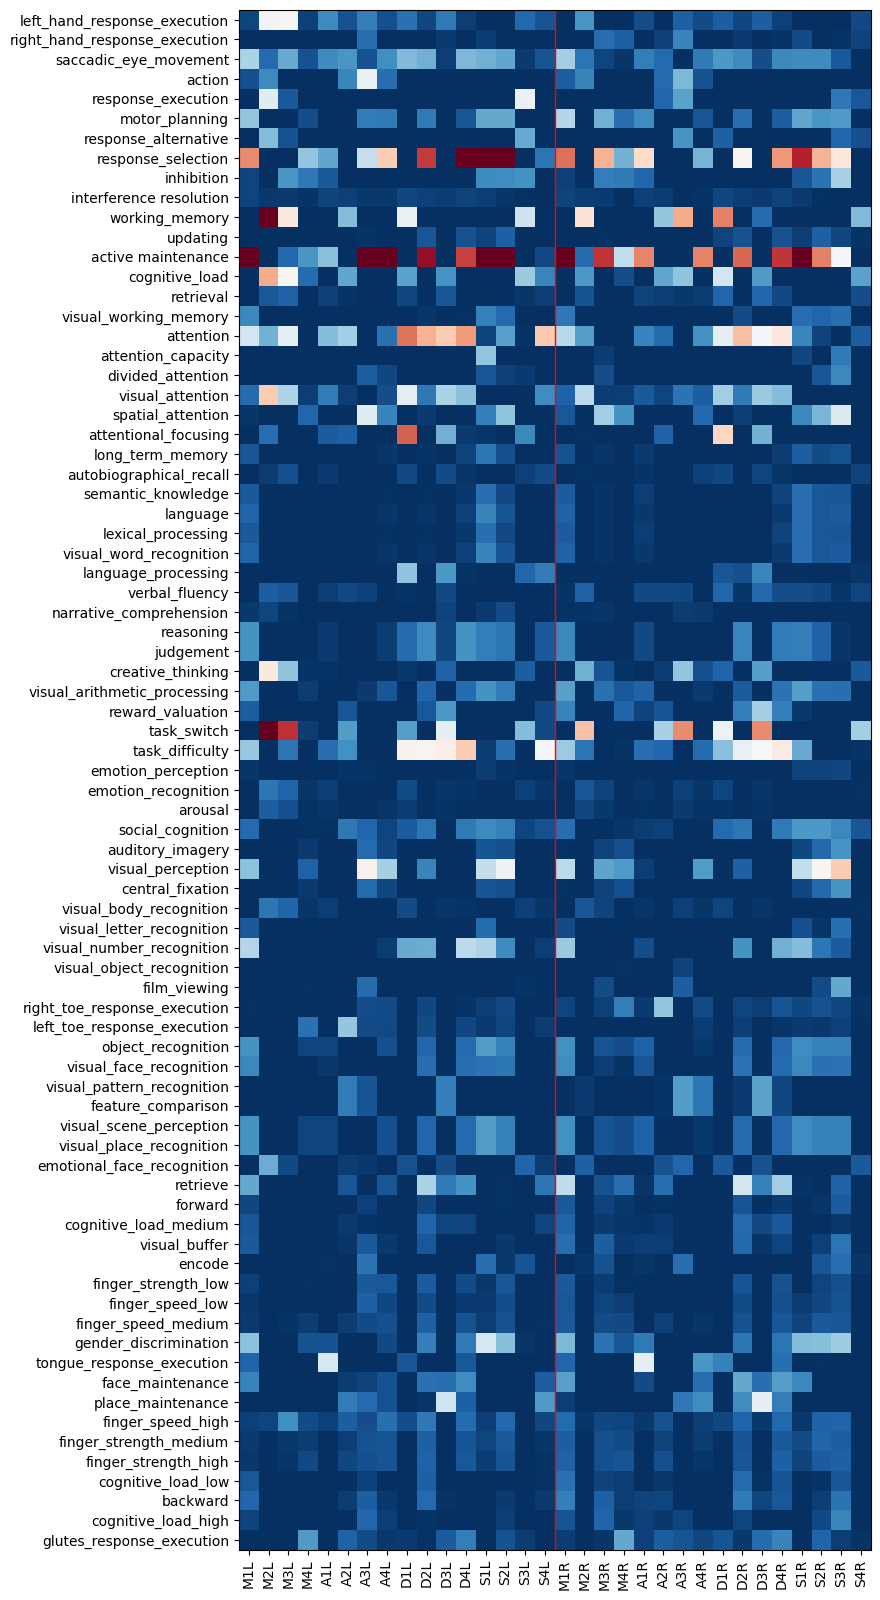

In [553]:
# Plot
plt.figure(figsize=(20, 20))
plt.imshow(features, vmin=0, vmax=0.09, cmap=cmap_matrix)
plt.xticks(np.arange(Features.shape[0]), Features.index, rotation=90)
plt.yticks(np.arange(Features.shape[1]), Features.columns)
# Plot a medial line
plt.plot([len(Features.index)/2-0.5, len(Features.index)/2-0.5], [-0.5, len(Features.columns)-0.5], color='red', linewidth=1)


# Show highest features

In [550]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns)
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [551]:
for region in ['M1L', 'M1R']:
    print_tags(features, Features, labels, region=region, n=2)

for region in ['M2L', 'M2R']:
    print_tags(features, Features, labels, region=region, n=2)





region M1L
active maintenance: 0.11474931533725964
response_selection: 0.06626818869876189

region M1R
active maintenance: 0.1253235172623891
response_selection: 0.06976558036411176

region M2L
task_switch: 0.1376761924385754
working_memory: 0.13263961495476492

region M2R
task_switch: 0.05815503935868973
working_memory: 0.05103366774254487


In [552]:

for region in ['M3L', 'M3R']:
    print_tags(features, Features, labels, region=region, n=2)

for region in ['M4L', 'M4R']:
    print_tags(features, Features, labels, region=region, n=2)


region M3L
task_switch: 0.07801770483707211
working_memory: 0.04951640962014132

region M3R
active maintenance: 0.07764195503629447
response_selection: 0.06073453930711624

region M4L
response_selection: 0.02722154700074208
glutes_response_execution: 0.019526022374768026

region M4R
active maintenance: 0.03400435430557548
response_selection: 0.023760675354114944
